In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

DATA_ROOT = "/content/drive/MyDrive/Lab19_images"
IMG_SIZE  = (224, 224)
BATCH     = 32
SEED      = 1337
AUTOTUNE  = tf.data.AUTOTUNE

# 80/20 split from the UNSPLIT directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training")

valtest_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="validation")

# split the 20% into 10% val + 10% test
valtest_count = tf.data.experimental.cardinality(valtest_ds).numpy()
test_ds = valtest_ds.take(max(1, valtest_count // 2))
val_ds = valtest_ds.skip(max(1, valtest_count // 2))

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

def format_example(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augment_example(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    return image, label

# Apply preprocessing
train_ds = train_ds.map(format_example, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(format_example,   num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(format_example,  num_parallel_calls=AUTOTUNE)

# Add augmentation to training only
train_ds = train_ds.map(augment_example, num_parallel_calls=AUTOTUNE)

# Cache & prefetch for speed
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)


Found 1220 files belonging to 7 classes.
Using 976 files for training.
Found 1220 files belonging to 7 classes.
Using 244 files for validation.
Classes: ['AMPHIBIAN', 'BIRD', 'FISH', 'INSECT', 'MAMMAL', 'MARINE_INVERTEBRATE', 'REPTILE']


In [ ]:
base = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE+(3,), include_top=False, weights='imagenet')
base.trainable = False  # stage 1

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
hist_head = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early])

# fine-tune last ~21 layers
base.trainable = True
for layer in base.layers[:-21]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hist_ft = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early])



Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.2412 - loss: 2.0796 - val_accuracy: 0.7328 - val_loss: 0.8449
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.6692 - loss: 0.8769 - val_accuracy: 0.7931 - val_loss: 0.5549
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 932ms/step - accuracy: 0.7871 - loss: 0.5902 - val_accuracy: 0.8276 - val_loss: 0.4697
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 921ms/step - accuracy: 0.8286 - loss: 0.4732 - val_accuracy: 0.8621 - val_loss: 0.4135
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8590 - loss: 0.4006 - val_accuracy: 0.8534 - val_loss: 0.3820
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 956ms/step - accuracy: 0.8733 - loss: 0.3667 - val_accuracy: 0.8276 - val_loss: 0.3705
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 984ms/step - accuracy: 0.9054 - loss: 0.3015 - val_accuracy: 0.8103 - val_loss: 0.3702
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 946ms/step - accuracy: 0.9163 - loss: 0.2691 - val_accuracy: 0.8

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8771 - loss: 0.2414
Test accuracy:  0.859375


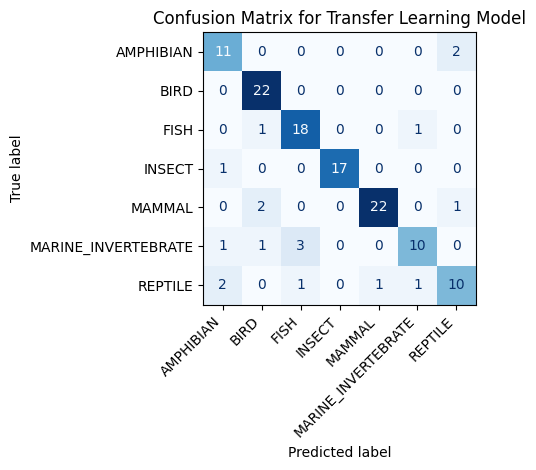

Classification report:

                     precision    recall  f1-score   support

          AMPHIBIAN      0.733     0.846     0.786        13
               BIRD      0.846     1.000     0.917        22
               FISH      0.818     0.900     0.857        20
             INSECT      1.000     0.944     0.971        18
             MAMMAL      0.957     0.880     0.917        25
MARINE_INVERTEBRATE      0.833     0.667     0.741        15
            REPTILE      0.769     0.667     0.714        15

           accuracy                          0.859       128
          macro avg      0.851     0.843     0.843       128
       weighted avg      0.863     0.859     0.857       128



In [ ]:
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1) Evaluate on the test set
loss, acc = model.evaluate(test_ds)
print(f"Test accuracy: {acc: }")

# 2) Get predictions + true labels
y_true = tf.concat([y for _, y in test_ds], axis=0).numpy()
y_prob = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# 3) Confusion matrix —
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.title("Confusion Matrix for Transfer Learning Model")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4) Per-class metrics (precision/recall/F1)
print("Classification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))


In [ ]:
# ----- From Tess

# Save keras model

h5_path = "/content/drive/MyDrive/Lab19_model.keras"
model.save(h5_path)
print("Saved!", h5_path)

# --- Convert to TFLITE

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# --- optimizes the size and performance
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# --- makes the model smaller, faster gpu but gives the same result
converter.target_spec.supported_types = [tf.float16]

# -- convert the model

tflite_model = converter.convert()

# -- save the model as a file

tflite_path = "/content/drive/MyDrive/Lab19_model.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print("Saved!", tflite_path)

# --- load thee model to verify it works

interpreter = tf.lite.Interpreter(model_path=tflite_path)
# - prep the model to be able to run redictions
interpreter.allocate_tensors()
# get details aabout the input and output, ex. foramtting or size
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Inputs:", input_details)
print("Outputs:", output_details)
#prints if its successfull
print("TFLite model loaded successfully")

Saved! /content/drive/MyDrive/Lab19_model.keras
Saved artifact at '/tmp/tmpdqamci5m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  133208900445840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133208900446224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133208900448528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133208900448144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133208900447568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133208900446032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133208900448720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133208900449488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133208900449104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133208900446416: TensorSpec(shap

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Model loaded
Inputs: [  1 224 224   3]
Outputs: [1 7]
Saved class names: ['AMPHIBIAN', 'BIRD', 'FISH', 'INSECT', 'MAMMAL', 'MARINE_INVERTEBRATE', 'REPTILE']


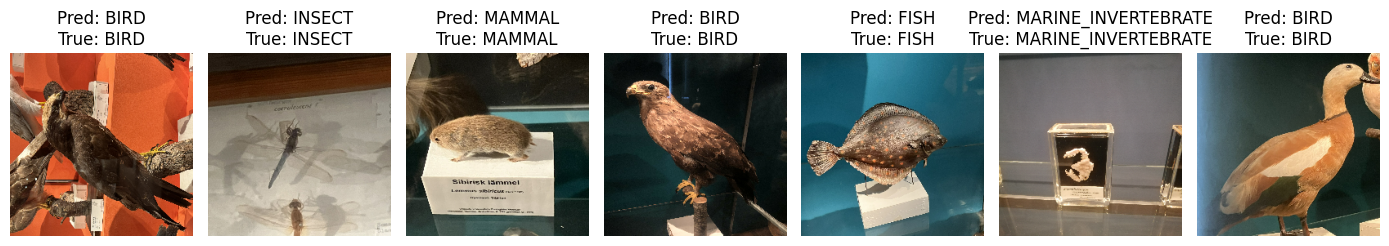

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Comparision keras vs TFLite: 
Image 1: Keras= BIRD,TFLite=BIRD
Image 2: Keras= INSECT,TFLite=INSECT
Image 3: Keras= MAMMAL,TFLite=MAMMAL
Image 4: Keras= BIRD,TFLite=BIRD
Image 5: Keras= FISH,TFLite=FISH
Image 6: Keras= MARINE_INVERTEBRATE,TFLite=MARINE_INVERTEBRATE
Image 7: Keras= BIRD,TFLite=BIRD


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

import tensorflow.lite as tflite

# Load the saved TFLite model
tflite_path = "/content/drive/MyDrive/Lab19_model.tflite"

interpreter = tflite.Interpreter(model_path=tflite_path)

# -- initiate the model so it can recieve dataa
interpreter.allocate_tensors()

# fetch info about input and output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Model loaded")
print("Inputs:", input_details[0]['shape'])
print("Outputs:", output_details[0]['shape'])

# - fetch a small sample set batch with images and labels and takes the 7 first images to show example.

for images, labels in test_ds.take(1): #sample_images, sample_labels = list(test_ds.take(1))[0] works aswell.
    sample_images = images[:7].numpy()
    sample_labels = labels[:7].numpy()
    print("Saved class names:", class_names)

# --- function makes a prediction with tflite model for one picture
def predict_tflite_image(image):
    # Expand to batch dimension and convert to float 32
    image = np.expand_dims(image, axis=0).astype(np.float32)

    # send the picture to the model
    interpreter.set_tensor(input_details[0]['index'], image)

    # run the model (prediction)
    interpreter.invoke()

    # get the result
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # removes unneccissary dimensions. aand reutrns classs predictions
    return np.squeeze(output_data)

# # "draw" the iamges with models predictions
plt.figure(figsize=(14, 4))
for i, img in enumerate(sample_images):
    preds = predict_tflite_image(img)
    pred_class = np.argmax(preds)
    true_class = sample_labels[i]

    plt.subplot(1, 7, i + 1)
    plt.imshow(np.clip(img, 0, 1)) #securing the image value 0.1
    plt.title(f"Pred: {class_names[pred_class]}\nTrue: {class_names[true_class]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

keras_preds = np.argmax(model.predict(sample_images), axis=1) #running the original model keras on the same images
#--- counts the tflite pred and prints out keras and tflite
print("Comparision keras vs TFLite: ")
for i in range(len(sample_images)):
    tflite_pred = np.argmax(predict_tflite_image(sample_images[i]))
    print (f"Image {i+1}: Keras= {class_names[keras_preds[i]]},TFLite={class_names[tflite_pred]}")